<a href="https://colab.research.google.com/github/MEskerod/project_deeplearning_2023/blob/main/deeplearning_project_Maria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import all
import tarfile, os, torch
from torchsummary import summary

import random as rd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from fnmatch import fnmatch

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

from torch.nn.modules import padding
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.functional import leaky_relu
from torch.nn.functional import relu

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/RNAStralign.tar.gz' #Change!

# Define the folder where you want to unzip the files (in-memory)
extracted_folder = '/content/sequences' #Change name?!

# Import files

In [4]:
# Create the destination folder (in-memory)
os.makedirs(extracted_folder, exist_ok=True)

# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(extracted_folder)

# List the files in the extracted folder
os.listdir(extracted_folder)

['RNAStrAlign-master-aedbaf9e95ebad34d15752fe1b750f5ff3960bca']

In [5]:
root = extracted_folder
pattern = "*.ct"

ct_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            ct_files.append(os.path.join(path, name))
with open("ct_files.txt", "w") as output:
    output.write("\n".join(ct_files))


### Picking files

In [6]:
def singleFamily(family: str, txt_file="ct_files.txt") -> list:
    '''
    Returns list of files from a single specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family in line:
                ct_files.append(line.strip())
    return ct_files

def leaveOneFamilyOut(family: str, txt_file="ct_files.txt"):
    '''
    Returns list of files from all families except the specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family not in line:
                ct_files.append(line.strip())
    return ct_files

def pickFromFamilies(data_size, txt_file="ct_files.txt"):
    '''
    Returns a list of files with data_size from EACH family.
    If a family does not have enough data, all data from that family is added.
    '''
    ct_files = []
    with open(txt_file, "r") as file: #Read paths to ct_files
        for line in file:
            if not line.startswith("#"):
                ct_files.append(line.strip())

    families = []
    for file in ct_files: #Find all family names
        #print(file.split("/"))
        families.append(file.split(os.sep)[4])
    families = list(set(families)) #Remove duplicates
    print(families)

    data = [] #Create list of lists, where each list contains all files from a family
    for family in families:
        data.append([line for line in ct_files if family in line])

    ct_files = []
    for family in data: #Pick data_size files from each family
      try:
          ct_files+=rd.sample(family, data_size)
      except:
          print("Not enough data in family: ", family[0].split(os.sep)[4], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")
          ct_files+=family
    return ct_files

def getLength(ct_file):
    '''
    Opens a ct_file and returns the length of the sequence as it appears in the first line.
    '''
    with open(ct_file, "r") as f:
      for line in f:
        length = int(line.split()[0])
        break
    return length

def underGivenLength(length, data_size, txt_file="ct_files.txt"):
  '''
  Returns a list of files under length with data_size from EACH family.
  If a family does not have enough data, all data from that family is added.
  '''
  ct_files = []
  with open(txt_file, "r") as file: #Read paths to ct_files
      for line in file:
          if not line.startswith("#"):
              ct_files.append(line.strip())

  families = []
  for file in ct_files: #Find all family names
      families.append(file.split(os.sep)[4])
  families = list(set(families)) #Remove duplicates

  data = [] #Create list of lists, where each list contains all files from a family
  for family in families:
      data.append([line for line in ct_files if family in line and getLength(line)<length])

  ct_files = []
  for family in data: #Pick data_size files from each family
      try:
          ct_files+=rd.sample(family, data_size)
      except:
          print("Not enough data in family, adding all")
          #print("Not enough data in family: ", family[0].split(os.sep)[4], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")
          ct_files+=family
  return ct_files


# Set up preprocessing of RNA files   

Below are the functions that is needed for processing the files from .ct files to images

In [7]:
def read_bpseq(file: str) -> tuple():
    """
    Takes a .bpseq file and returns the sequence as a string and a list of base pairs
    """

    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    #Make sequence in bp list
    for line in lines:
        sequence += line[1]
        if line[2] != '0':
            pairs.append((int(line[0])-1, int(line[2])-1)) #The files start indexing from 1
    return sequence, pairs

def read_ct(file: str) -> tuple():
    """
    Takes a .ct file and returns the sequence as a string and a list of base pairs
    """
    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    for line in lines:
        sequence += line[1]
        if line[4] != '0':
            pairs.append((int(line[0])-1, int(line[4])-1)) #The files start indexing from 1

    return sequence, pairs

In [8]:
def make_matrix_from_sequence(sequence: str) -> np.array:
    """
    A sequence is converted to a matrix containing all the possible base pairs

    If the bases does not form  valid pair the cell is white.
    The valid base pairs has the following colors:
    GC = green
    CG = dark green
    UG = blue
    GU = dark blue
    UA = red
    AU = dark red
    """
    colors = {"invalid_pairing": [255, 255, 255],
              "unpaired": [64, 64, 64],
              "GC": [0, 255, 0],
              "CG": [0, 128, 0],
              "UG": [0, 0, 255],
              "GU": [0, 0, 128],
              "UA": [255, 0, 0],
              "AU": [128, 0, 0]}
    basepairs = ["GC", "CG", "UG", "GU", "UA", "AU"]

    N = len(sequence)

    matrix = np.full((N,N,3),255, dtype="uint8")

    for i in range(N):
        for j in range(N):
            pair = sequence[i] + sequence[j]
            if i == j:
                matrix[i, j, :] = colors["unpaired"]
            elif pair in basepairs:
                matrix[i, j, :] = colors[pair]

    return matrix


def make_matrix_from_basepairs(sequence: str, pairs: list) -> np.array:
    """
    Takes a list of all the base pairs.
    From the list a matrix is made, with each cell coresponding to a base pair colered black
    """
    black = [0, 0, 0]

    N = len(sequence)
    matrix = np.full((N,N,3),255, dtype="uint8")

    for pair in pairs:
        matrix[pair[0], pair[1], :] = black

    return matrix

In [9]:
def save_matrix(matrix: np.array, name: str) -> None:
    """
    Saves the matrix as a .png file
    """
    plt.imsave(name, matrix)

# Convert sequences
The sequences needs to be read from the .ct files and converted into images that can be used as input to the CNN.    

In [10]:

def getCtFromTxt(txt_file):
    """
    Takes a txt file containing the path to all the ct files and returns a list of the paths
    """
    with open(txt_file, 'r') as f:
        ct_files = f.readlines()
    ct_files = [file.strip() for file in ct_files if file.strip()[0] != "#"]
    return ct_files

def save_to_matrices(file_list, input_matrix_path, output_matrix_path):
    """
    For every file supplied in file_list:
      a matrix of all possible base pairs is saved to input_matrix_path
      a matrix showing the base pairs in the actual sequence is saved to output_matrix_path
    """
    for file_name in file_list:
        sequence, pairs = read_ct(file_name)
        input_matrix = make_matrix_from_sequence(sequence)
        save_matrix(input_matrix, os.path.join(input_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))
        output_matrix = make_matrix_from_basepairs(sequence, pairs)
        save_matrix(output_matrix, os.path.join(output_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))

In [11]:
#TODO - Change to different file list! This is just for testing.

ct_files = getCtFromTxt("ct_files.txt")

#file_list = []

#for file_name in ct_files:
    #if "tRNA_database" in file_name:
    #    file_list.append(file_name)

file_list = leaveOneFamilyOut("5S_rRNA")

with open("ct_files_no_5S.txt", "w") as output:
    output.write("\n".join(file_list))

file_list = underGivenLength(500, 5000, "ct_files_no_5S.txt")

len(file_list)



Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all


9631

In [12]:
input_matrix_path = "input"
output_matrix_path = "result"

# Create folders for images
os.makedirs(input_matrix_path, exist_ok=True)
os.makedirs(output_matrix_path, exist_ok=True)

save_to_matrices(file_list, input_matrix_path, output_matrix_path)


# Set up data for network

### Splitting data into train and validation sets

In [13]:
def move_files(src_dir, dst_dir, file_list):
    for filename in file_list:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        os.rename(src_path, dst_path)

In [14]:
#Make directories
directories = ['train', 'validation']
subdirectories = ['input_images', 'output_images']

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    for subdirectory in subdirectories:
        dir_path = os.path.join(directory, subdirectory)
        os.makedirs(dir_path, exist_ok=True)

In [15]:
#List input and outputs
input_images = os.listdir(input_matrix_path)
output_images = os.listdir(output_matrix_path)

#Make split
input_train, input_valid, output_train, output_valid = train_test_split(input_images, output_images, train_size=0.8, random_state=42, shuffle=True) #NOTE - Change to the fraction we want nd whether we want shuffle or not


#Move files to train and validation folders
train_input_dir = 'train/input_images'
train_output_dir = 'train/output_images'
val_input_dir = 'validation/input_images'
val_output_dir = 'validation/output_images'

move_files(input_matrix_path, train_input_dir, input_train)
move_files(output_matrix_path, train_output_dir, output_train)
move_files(input_matrix_path, val_input_dir, input_valid)
move_files(output_matrix_path, val_output_dir, output_valid)

### Read data and set up data loader

In [16]:
dataTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
])

class ImageToImageDataset(Dataset):
    """

    """
    def __init__(self, input_dir, output_dir, input_transform = dataTransformer, output_transform = dataTransformer):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = os.listdir(input_dir)
        self.output_files = os.listdir(output_dir)
        self.input_transform = input_transform
        self.output_transform = output_transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image =  plt.imread(os.path.join(self.input_dir, self.input_files[idx]))
        output_image = plt.imread(os.path.join(self.output_dir, self.output_files[idx]))

        input_image = self.input_transform(input_image)
        output_image = self.output_transform(output_image)

        return input_image, output_image



### Image transformers

In [17]:
def convert_to_grayscale(img):
  return torch.mean(img, dim=0, keepdim=True)

def drop_alpha(img):
  return img[:3, :, :]

grayscaleTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
    transforms.Lambda(convert_to_grayscale)
])

RGBTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
    transforms.Lambda(drop_alpha)
])

# Model

### User defined layers



In [18]:
class DynamicPadLayer(nn.Module):
  def __init__(self, stride_product):
    super(DynamicPadLayer, self).__init__()
    self.stride_product = stride_product

  def forward(self, x):
    input_size = x.shape[2]
    padding = self.calculate_padding(input_size, self.stride_product)
    return nn.functional.pad(x, padding)

  def calculate_padding(self, input_size, stride_product):
    p = stride_product - input_size % stride_product
    return (0, p, 0, p)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

### Models

In [19]:
#Original model with extra layers (Rasmus)
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class RNASecondaryStructureCAE(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNASecondaryStructureCAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels * 2,
                kernel_size=3,
                padding=1,
                # Maybe use dilation in deeper layers?
            ),
            nn.BatchNorm2d(out_channels * 2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(in_channels=out_channels * 2,
                      out_channels=out_channels * 4,
                      kernel_size=3,
                      padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # Doesn't make sense for our data?
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=out_channels * 4,
                out_channels=out_channels * 2,
                kernel_size=3,
                stride=2
            ),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(
                in_channels=out_channels * 2,
                out_channels=out_channels,
                kernel_size=3,
                padding=1
            ),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(
                in_channels=out_channels,
                out_channels=in_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.Sigmoid()
        )

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        if dim%2 == 0:
          x = nn.functional.pad(x, (0, 1, 0, 1))

        x = self.encoder(x)
        x = self.decoder(x)

        x = x[:, :, :dim, :dim]
        return x

In [20]:
#Autoencoder (Johan)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class RNA_Unet11(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet11, self).__init__()

        self.pad = DynamicPadLayer(2**2)

        # Encoder
        self.bn11 = nn.BatchNorm2d(out_channels*2)
        self.e11 = nn.Conv2d(in_channels, out_channels*2, kernel_size=3, padding=1, stride=2)
        self.bn12 = nn.BatchNorm2d(out_channels*2)
        self.e12 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.bn13 = nn.BatchNorm2d(out_channels*2)
        self.e13 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.bn21 = nn.BatchNorm2d(out_channels*4)
        self.e21 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, stride=2, padding=1)
        self.bn22 = nn.BatchNorm2d(out_channels*4)
        self.e22 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.d11 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(out_channels*2, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.out = nn.Sigmoid()

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):

        dim = x.shape[2]
        x = self.pad(x)
        #Encoder
        xe11 = self.bn11(relu(self.e11(x)))
        xe12 = self.bn12(relu(self.e12(xe11)))
        xe13 = self.bn13(relu(self.e13(xe12)))

        xe21 = self.bn21(relu(self.e21(xe13)))
        xe22 = self.bn22(relu(self.e22(xe21)))

        #Decoder
        xu1 = relu(self.upconv1(xe22))
        xd11 = relu(self.d11(xu1))

        xu2 = relu(self.upconv2(xd11))

        xout = self.out(xu2)

        xcrop = xout[:, :, :dim, :dim]

        return xcrop

In [21]:
#Johan with leaky ReLU

class RNA_Unet12(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet12, self).__init__()

        self.pad = DynamicPadLayer(2**2)

        # Encoder
        self.bn11 = nn.BatchNorm2d(out_channels*2)
        self.e11 = nn.Conv2d(in_channels, out_channels*2, kernel_size=3, padding=1, stride=2)
        self.bn12 = nn.BatchNorm2d(out_channels*2)
        self.e12 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.bn13 = nn.BatchNorm2d(out_channels*2)
        self.e13 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.bn21 = nn.BatchNorm2d(out_channels*4)
        self.e21 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, stride=2, padding=1)
        self.bn22 = nn.BatchNorm2d(out_channels*4)
        self.e22 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.d11 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(out_channels*2, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.out = nn.Sigmoid()

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):

        dim = x.shape[2]
        x = self.pad(x)
        #Encoder
        xe11 = self.bn11(leaky_relu(self.e11(x)))
        xe12 = self.bn12(leaky_relu(self.e12(xe11)))
        xe13 = self.bn13(leaky_relu(self.e13(xe12)))

        xe21 = self.bn21(leaky_relu(self.e21(xe13)))
        xe22 = self.bn22(leaky_relu(self.e22(xe21)))

        #Decoder
        xu1 = leaky_relu(self.upconv1(xe22))
        xd11 = leaky_relu(self.d11(xu1))

        xu2 = leaky_relu(self.upconv2(xd11))

        xout = self.out(xu2)

        xcrop = xout[:, :, :dim, :dim]

        return xcrop

In [22]:
#Autoencoder with pooling (Maria)

class RNA_Unet21(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet21, self).__init__()

        self.pad = DynamicPadLayer(2**3)

        # Encoder
        self.bn11 = nn.BatchNorm2d(out_channels)
        self.e11 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn12 = nn.BatchNorm2d(out_channels)
        self.e12 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn13 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(out_channels * 2)
        self.e21 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(out_channels * 2)
        self.e22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(out_channels * 2)
        self.pool2 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(out_channels*4)
        self.e31 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(out_channels*4)
        self.e32 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(out_channels*4)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2)

        #Decoder
        self.upconv1 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

        self.out = nn.Sigmoid()

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = self.bn11(leaky_relu(self.e11(x)))
        xe12 = self.bn12(leaky_relu(self.e12(xe11)))
        xp1 = self.bn13(self.pool1(xe12))

        xe21 = self.bn21(leaky_relu(self.e21(xp1)))
        xe22 = self.bn22(leaky_relu(self.e22(xe21)))
        xp2 = self.bn23(self.pool2(xe22))

        xe31 = self.bn31(leaky_relu(self.e31(xp2)))
        xe32 = self.bn32(leaky_relu(self.e32(xe31)))
        xp3 = self.bn33(self.pool3(xe32))

        #Decoder
        xu1 = self.upconv1(xp3)
        xd11 = leaky_relu(self.d11(xu1))

        xu2 = self.upconv2(xd11)
        xd21 = leaky_relu(self.d21(xu2))

        xu3 = self.upconv3(xd21)
        xd31 = leaky_relu(self.d31(xu3))

        out = self.out(xd31)
        out = out[:, :, :dim, :dim]

        return out

In [23]:
#Autoencoder ala Maria with even more layers

class RNA_Unet22(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet22, self).__init__()

        self.pad = DynamicPadLayer(2**4)

        # Encoder
        self.bn11 = nn.BatchNorm2d(out_channels)
        self.e11 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn12 = nn.BatchNorm2d(out_channels)
        self.e12 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn13 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(out_channels * 2)
        self.e21 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(out_channels * 2)
        self.e22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(out_channels * 2)
        self.pool2 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(out_channels*4)
        self.e31 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(out_channels*4)
        self.e32 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(out_channels*4)
        self.pool3 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=2, stride=2)

        self.bn41 = nn.BatchNorm2d(out_channels*8)
        self.e41 = nn.Conv2d(out_channels*4, out_channels*8, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(out_channels*8)
        self.e42 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(out_channels*8)
        self.pool4 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=2, stride=2)

        self.bn51 = nn.BatchNorm2d(out_channels*16)
        self.e51 = nn.Conv2d(out_channels*8, out_channels*16, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(out_channels*16)
        self.e52 = nn.Conv2d(out_channels*16, out_channels*16, kernel_size=3, padding=1)

        #Decoder
        self.bn61 = nn.BatchNorm2d(out_channels*8)
        self.upconv1 = nn.ConvTranspose2d(out_channels*16, out_channels*8, kernel_size=2, stride=2)
        self.bn62 = nn.BatchNorm2d(out_channels*8)
        self.d11 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1)
        self.bn63 = nn.BatchNorm2d(out_channels*8)
        self.d12 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1)

        self.bn71 = nn.BatchNorm2d(out_channels*4)
        self.upconv2 = nn.ConvTranspose2d(out_channels*8, out_channels*4, kernel_size=2, stride=2)
        self.bn72 = nn.BatchNorm2d(out_channels*4)
        self.d21 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.bn73 = nn.BatchNorm2d(out_channels*4)
        self.d22 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)

        self.bn81 = nn.BatchNorm2d(out_channels*2)
        self.upconv3 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=2, stride=2)
        self.bn82 = nn.BatchNorm2d(out_channels*2)
        self.d31 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.bn83 = nn.BatchNorm2d(out_channels*2)
        self.d32 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.bn91 = nn.BatchNorm2d(out_channels)
        self.upconv4 = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=2, stride=2)
        self.bn92 = nn.BatchNorm2d(out_channels)
        self.d41 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn93 = nn.BatchNorm2d(out_channels)
        self.d42 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(nn.Conv2d(out_channels, in_channels, kernel_size=3, padding=1),
                                 nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = self.bn11(leaky_relu(self.e11(x)))
        xe12 = self.bn12(leaky_relu(self.e12(xe11)))
        xp1 = self.bn13(self.pool1(xe12))

        xe21 = self.bn21(leaky_relu(self.e21(xp1)))
        xe22 = self.bn22(leaky_relu(self.e22(xe21)))
        xp2 = self.bn23(self.pool2(xe22))

        xe31 = self.bn31(leaky_relu(self.e31(xp2)))
        xe32 = self.bn32(leaky_relu(self.e32(xe31)))
        xp3 = self.bn33(self.pool3(xe32))

        xe41 = self.bn41(leaky_relu(self.e41(xp3)))
        xe42 = self.bn42(leaky_relu(self.e42(xe41)))
        xp4 = self.bn43(self.pool4(xe42))

        xe51 = self.bn51(leaky_relu(self.e51(xp4)))
        xe52 = self.bn52(leaky_relu(self.e52(xe51)))

        #Decoder
        xu1 = self.bn61(leaky_relu(self.upconv1(xe52)))
        xd11 = self.bn62(leaky_relu(self.d11(xu1)))
        xd12 = self.bn63(leaky_relu(self.d12(xd11)))

        xu2 = self.bn71(leaky_relu(self.upconv2(xd12)))
        xd21 = self.bn72(leaky_relu(self.d21(xu2)))
        xd22 = self.bn73(leaky_relu(self.d22(xd21)))

        xu3 = self.bn81(leaky_relu(self.upconv3(xd22)))
        xd31 = self.bn81(leaky_relu(self.d31(xu3)))
        xd32 = self.bn83(leaky_relu(self.d32(xd31)))

        xu4 = self.bn91(leaky_relu(self.upconv4(xd32)))
        xd41 = self.bn92(leaky_relu(self.d41(xu4)))
        xd42 = self.bn93(leaky_relu(self.d42(xd41)))

        out = self.out(xd42)

        out = out[:, :, :dim, :dim]

        return out

In [24]:
#Unet with pooling

class RNA_Unet_skipl(nn.Module):
    def __init__(self, out_channels, in_channels=4):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet_skipl, self).__init__()

        self.pad = DynamicPadLayer(2**4)

        # Encoder
        self.bn11 = nn.BatchNorm2d(out_channels)
        self.e11 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn12 = nn.BatchNorm2d(out_channels)
        self.e12 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.bn13 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(out_channels * 2)
        self.e21 = nn.Conv2d(out_channels, out_channels*2, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(out_channels * 2)
        self.e22 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(out_channels * 2)
        self.pool2 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(out_channels*4)
        self.e31 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(out_channels*4)
        self.e32 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(out_channels*4)
        self.pool3 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=2, stride=2)

        self.bn41 = nn.BatchNorm2d(out_channels*8)
        self.e41 = nn.Conv2d(out_channels*4, out_channels*8, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(out_channels*8)
        self.e42 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(out_channels*8)
        self.pool4 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=2, stride=2)

        self.bn51 = nn.BatchNorm2d(out_channels*16)
        self.e51 = nn.Conv2d(out_channels*8, out_channels*16, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(out_channels*16)
        self.e52 = nn.Conv2d(out_channels*16, out_channels*16, kernel_size=3, padding=1)

        #Decoder
        self.bn61 = nn.BatchNorm2d(out_channels*8)
        self.upconv1 = nn.ConvTranspose2d(out_channels*16, out_channels*8, kernel_size=2, stride=2)
        self.bn62 = nn.BatchNorm2d(out_channels*8)
        self.d11 = nn.Conv2d(out_channels*16, out_channels*8, kernel_size=3, padding=1)
        self.bn63 = nn.BatchNorm2d(out_channels*8)
        self.d12 = nn.Conv2d(out_channels*8, out_channels*8, kernel_size=3, padding=1)

        self.bn71 = nn.BatchNorm2d(out_channels*4)
        self.upconv2 = nn.ConvTranspose2d(out_channels*8, out_channels*4, kernel_size=2, stride=2)
        self.bn72 = nn.BatchNorm2d(out_channels*4)
        self.d21 = nn.Conv2d(out_channels*8, out_channels*4, kernel_size=3, padding=1)
        self.bn73 = nn.BatchNorm2d(out_channels*4)
        self.d22 = nn.Conv2d(out_channels*4, out_channels*4, kernel_size=3, padding=1)

        self.bn81 = nn.BatchNorm2d(out_channels*2)
        self.upconv3 = nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=2, stride=2)
        self.bn82 = nn.BatchNorm2d(out_channels*2)
        self.d31 = nn.Conv2d(out_channels*4, out_channels*2, kernel_size=3, padding=1)
        self.bn83 = nn.BatchNorm2d(out_channels*2)
        self.d32 = nn.Conv2d(out_channels*2, out_channels*2, kernel_size=3, padding=1)

        self.bn91 = nn.BatchNorm2d(out_channels)
        self.upconv4 = nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=2, stride=2)
        self.bn92 = nn.BatchNorm2d(out_channels)
        self.d41 = nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1)
        self.bn93 = nn.BatchNorm2d(out_channels)
        self.d42 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(nn.Conv2d(out_channels, in_channels, kernel_size=3, padding=1),
                                 nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = self.bn11(leaky_relu(self.e11(x)))
        xe12 = self.bn12(leaky_relu(self.e12(xe11)))
        xp1 = self.bn13(self.pool1(xe12))

        xe21 = self.bn21(leaky_relu(self.e21(xp1)))
        xe22 = self.bn22(leaky_relu(self.e22(xe21)))
        xp2 = self.bn23(self.pool2(xe22))

        xe31 = self.bn31(leaky_relu(self.e31(xp2)))
        xe32 = self.bn32(leaky_relu(self.e32(xe31)))
        xp3 = self.bn33(self.pool3(xe32))

        xe41 = self.bn41(leaky_relu(self.e41(xp3)))
        xe42 = self.bn42(leaky_relu(self.e42(xe41)))
        xp4 = self.bn43(self.pool4(xe42))

        xe51 = self.bn51(leaky_relu(self.e51(xp4)))
        xe52 = self.bn52(leaky_relu(self.e52(xe51)))

        #Decoder
        xu1 = self.bn61(leaky_relu(self.upconv1(xe52)))
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = self.bn62(leaky_relu(self.d11(xu11)))
        xd12 = self.bn63(leaky_relu(self.d12(xd11)))

        xu2 = self.bn71(leaky_relu(self.upconv2(xd12)))
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = self.bn72(leaky_relu(self.d21(xu22)))
        xd22 = self.bn73(leaky_relu(self.d22(xd21)))

        xu3 = self.bn81(leaky_relu(self.upconv3(xd22)))
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = self.bn81(leaky_relu(self.d31(xu33)))
        xd32 = self.bn83(leaky_relu(self.d32(xd31)))

        xu4 = self.bn91(leaky_relu(self.upconv4(xd32)))
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = self.bn92(leaky_relu(self.d41(xu44)))
        xd42 = self.bn93(leaky_relu(self.d42(xd41)))

        out = self.out(xd42)

        out = out[:, :, :dim, :dim]

        return out

### Function for training the model

### Loss functions and other error metrics

In [25]:
def dice_loss(inputs, targets, smooth=1e-5):
  intersection = torch.sum(targets * inputs, dim=(1,2,3))
  sum_of_squares_pred = torch.sum(torch.square(inputs), dim=(1,2,3))
  sum_of_squares_true = torch.sum(torch.square(targets), dim=(1,2,3))
  dice = (2 * intersection + smooth) / (sum_of_squares_pred + sum_of_squares_true + smooth)
  return 1-dice

In [26]:
def accuracy(inputs, targets, treshold = 0.5):
  if inputs.shape != targets.shape:
        raise ValueError("ERROR: Input tensors must have the same shape.")

  correct_predicted = torch.sum((inputs >= treshold).float() == targets)
  total_elements = inputs.numel()
  return correct_predicted/total_elements

In [27]:
def f1_score(inputs, targets, epsilon=1e-7, treshold = 0.5):
    # Ensure tensors have the same shape
    assert inputs.shape == targets.shape

    binary_input = (inputs >= treshold).float()

    # Calculate true positives, false positives, and false negatives
    #Black (0) is considered the positive
    true_positives = torch.sum((1 - targets) * (1 - binary_input))
    false_positives = torch.sum(targets * (1 - binary_input))
    false_negatives = torch.sum((1 - inputs) * binary_input)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives + epsilon)
    recall = true_positives / (true_positives + false_negatives + epsilon)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1

### Optimizers

In [28]:
def adam_optimizer(model, lr):
  return torch.optim.Adam(model.parameters(), lr=lr)

### Plots for training

In [29]:
def show_matrices(inputs, observed, predicted, treshold=0.5):

  fig, axs = plt.subplots(1, 3, figsize=(6,2))
  #fig, axs = plt.subplots(1, 4, figsize=(8,2))

  axs[0].imshow(inputs.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[0].set_title("Input")

  axs[1].imshow(observed.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[1].set_title("Observed")

  axs[2].imshow(predicted.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[2].set_title("Predicted")

  #axs[3].imshow((predicted.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() >= treshold).float())
  #axs[3].set_title(f"Predicted treshold {treshold}")

  plt.tight_layout()
  plt.show()


def show_loss(train_loss, valid_loss, time):
  plt.figure()
  plt.plot(time, train_loss, label = "Training")
  plt.plot(time, valid_loss, label = "Valiation")
  plt.title("Loss")
  plt.legend()
  plt.show()

def show_acuracy(train_accuracy, valid_accuracy, time):
  plt.figure()
  plt.plot(time, train_accuracy, label = "Training")
  plt.plot(time, valid_accuracy, label = "Validation")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

def show_F1(train_F1, valid_F1, time):
  plt.figure()
  plt.plot(time, train_F1, label = "Training")
  plt.plot(time, valid_F1, label = "Validation")
  plt.title("F1 score")
  plt.legend()
  plt.show()


### Funcition for training

In [30]:
def fit_model(model, train_dataset, validation_dataset, loss_func = F.binary_cross_entropy, optimizer = adam_optimizer, lr=0.01, bs=1, epochs=5):
  train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  valid_dl = DataLoader(validation_dataset, batch_size=bs)

  opt = optimizer(model, lr)


  #Add stuff to track history
  train_loss_history = []
  #train_accuracy_history = []
  train_F1_history = []
  valid_loss_history = []
  #valid_accuracy_history = []
  valid_F1_history = []
  plot_time = []

  t = 0 #To keep track of time


  #Train for a given number of epochs
  for epoch in range(epochs):
    t+=1
    running_loss = 0.0
    #running_accuracy = 0.0
    running_F1 = 0.0
    model.train()

    for input, output in train_dl:
      #Forward pass
      predicted = model(input.cuda())

      #Compute loss
      loss = loss_func(predicted, output.cuda())
      running_loss += loss.item()

      #running_accuracy += accuracy(predicted, output.cuda()).item()
      running_F1 += f1_score(predicted, output.cuda()).item()

      # Backpropagation, optimization and zeroing the gradients
      loss.backward()
      opt.step()
      opt.zero_grad()

    #Validation loss (only after each epoch)
    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_func(model(input.cuda()), output.cuda()) for input, output in valid_dl)/len(valid_dl)
      #valid_accuracy = sum(accuracy(model(input.cuda()), output.cuda()) for input, output in valid_dl) / len(valid_dl)
      valid_F1 = sum(f1_score(model(input.cuda()), output.cuda()) for input, output in valid_dl) / len(valid_dl)
      valid_loss_history.append(valid_loss.detach().cpu().numpy())
      #valid_accuracy_history.append(valid_accuracy.detach().cpu().numpy())
      valid_F1_history.append(valid_F1.detach().cpu().numpy())
      train_loss_history.append(running_loss/len(train_dl))
      #train_accuracy_history.append(running_accuracy/len(train_dl))
      train_F1_history.append(running_F1/len(train_dl))
      plot_time.append(t)



    show_matrices(input, output, predicted)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {round(running_loss / len(train_dl),4)}, Validation: {valid_loss}")

  #Loss plot
  show_loss(train_loss_history, valid_loss_history, plot_time)
  #show_acuracy(train_accuracy_history, valid_accuracy_history, plot_time)
  show_F1(train_F1_history, valid_F1_history, plot_time)

  return train_loss_history, train_F1_history, valid_loss_history, valid_F1_history, plot_time


# Training models

In [36]:
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 201, 201]             296
       BatchNorm2d-2          [-1, 8, 201, 201]              16
         LeakyReLU-3          [-1, 8, 201, 201]               0
            Conv2d-4         [-1, 16, 201, 201]           1,168
       BatchNorm2d-5         [-1, 16, 201, 201]              32
         LeakyReLU-6         [-1, 16, 201, 201]               0
            Conv2d-7         [-1, 32, 201, 201]           4,640
         LeakyReLU-8         [-1, 32, 201, 201]               0
         MaxPool2d-9         [-1, 32, 100, 100]               0
  ConvTranspose2d-10         [-1, 16, 201, 201]           4,624
        LeakyReLU-11         [-1, 16, 201, 201]               0
  ConvTranspose2d-12          [-1, 8, 201, 201]           1,160
        LeakyReLU-13          [-1, 8, 201, 201]               0
  ConvTranspose2d-14          [-1, 4, 2

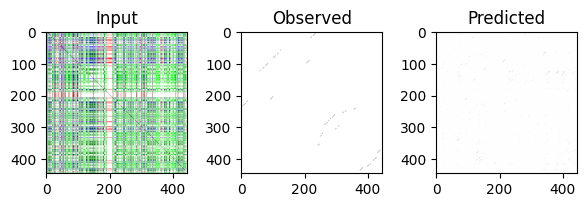

Epoch [1/5], Loss: 0.0121, Validation: 0.006463060155510902


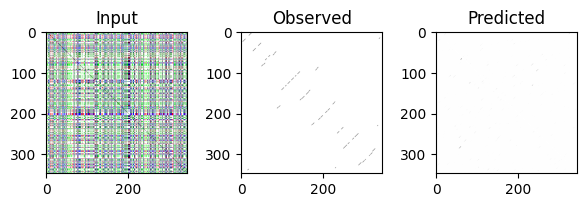

Epoch [2/5], Loss: 0.0057, Validation: 0.00764657324180007


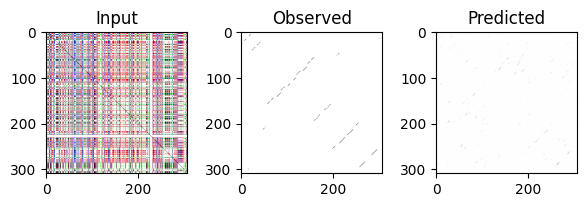

Epoch [3/5], Loss: 0.0054, Validation: 0.0063661253079771996


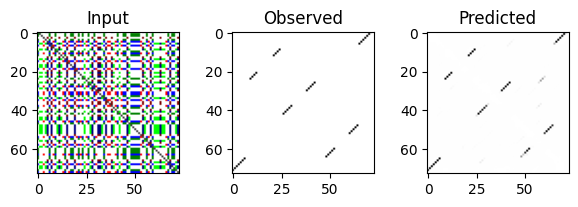

Epoch [4/5], Loss: 0.0051, Validation: 0.005486101843416691


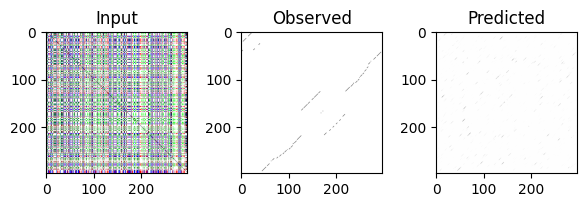

Epoch [5/5], Loss: 0.005, Validation: 0.0060654194094240665


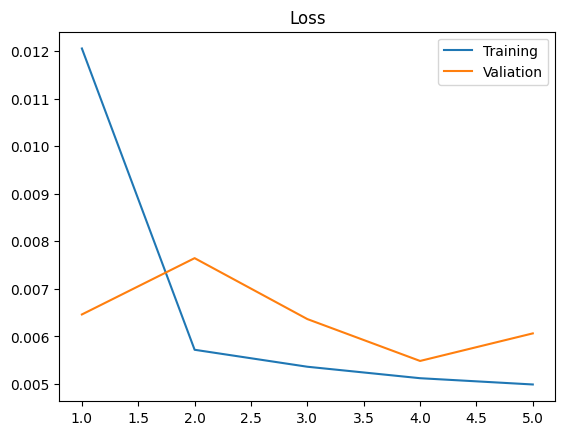

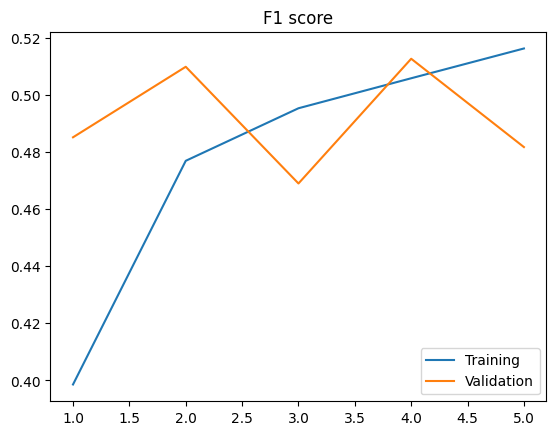

Finished training


In [39]:
#Original model
%matplotlib inline

channels = 8
model_original = RNASecondaryStructureCAE(channels).cuda()

summary(model_original, input_size=(4, 201, 201))

fit_model(model_original, train_dataset, validation_dataset)

print("Finished training")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 204, 204]               0
            Conv2d-2         [-1, 16, 102, 102]             592
       BatchNorm2d-3         [-1, 16, 102, 102]              32
            Conv2d-4         [-1, 16, 102, 102]           2,320
       BatchNorm2d-5         [-1, 16, 102, 102]              32
            Conv2d-6         [-1, 16, 102, 102]           2,320
       BatchNorm2d-7         [-1, 16, 102, 102]              32
            Conv2d-8           [-1, 32, 51, 51]           4,640
       BatchNorm2d-9           [-1, 32, 51, 51]              64
           Conv2d-10           [-1, 32, 51, 51]           9,248
      BatchNorm2d-11           [-1, 32, 51, 51]              64
  ConvTranspose2d-12         [-1, 16, 102, 102]           4,624
           Conv2d-13         [-1, 16, 102, 102]           2,320
  ConvTranspose2d-14          [-1, 4, 2

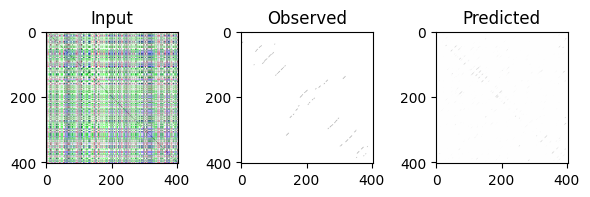

Epoch [1/5], Loss: 0.0082, Validation: 0.036814697086811066


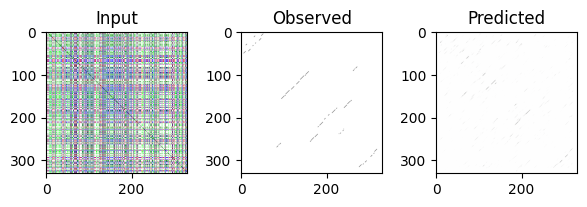

Epoch [2/5], Loss: 0.0054, Validation: 0.02602367289364338


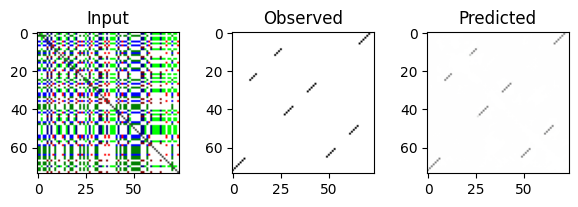

Epoch [3/5], Loss: 0.0052, Validation: 0.02554241009056568


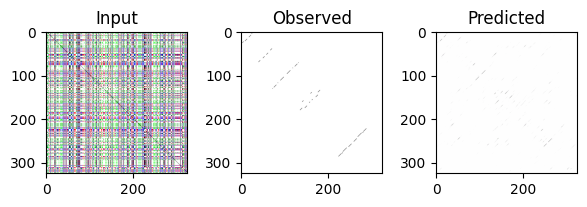

Epoch [4/5], Loss: 0.0052, Validation: 0.07976145297288895


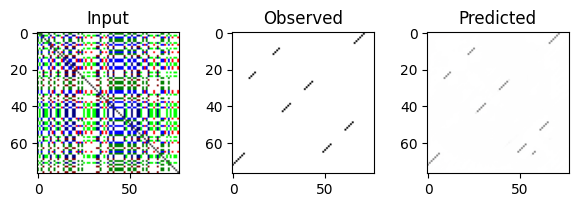

Epoch [5/5], Loss: 0.0051, Validation: 0.029974304139614105


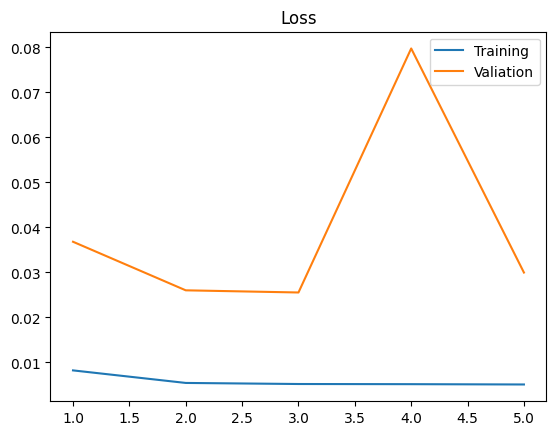

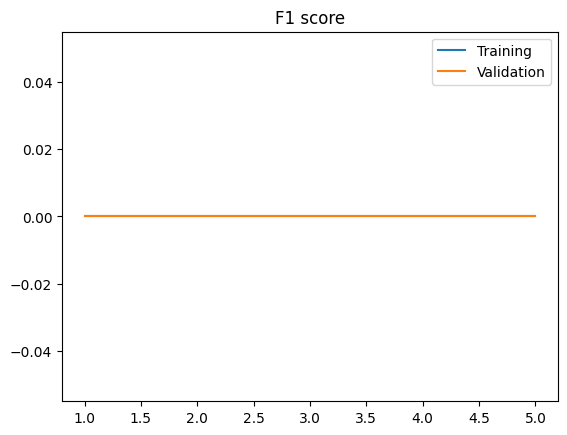

Finished training


In [46]:
#With more layers (Johan)
%matplotlib inline

channels = 8
model_Johan = RNA_Unet11(channels).cuda()

summary(model_Johan, input_size=(4, 201, 201))

fit_model(model_Johan, train_dataset, validation_dataset)

print("Finished training")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 204, 204]               0
            Conv2d-2         [-1, 16, 102, 102]             592
       BatchNorm2d-3         [-1, 16, 102, 102]              32
            Conv2d-4         [-1, 16, 102, 102]           2,320
       BatchNorm2d-5         [-1, 16, 102, 102]              32
            Conv2d-6         [-1, 16, 102, 102]           2,320
       BatchNorm2d-7         [-1, 16, 102, 102]              32
            Conv2d-8           [-1, 32, 51, 51]           4,640
       BatchNorm2d-9           [-1, 32, 51, 51]              64
           Conv2d-10           [-1, 32, 51, 51]           9,248
      BatchNorm2d-11           [-1, 32, 51, 51]              64
  ConvTranspose2d-12         [-1, 16, 102, 102]           4,624
           Conv2d-13         [-1, 16, 102, 102]           2,320
  ConvTranspose2d-14          [-1, 4, 2

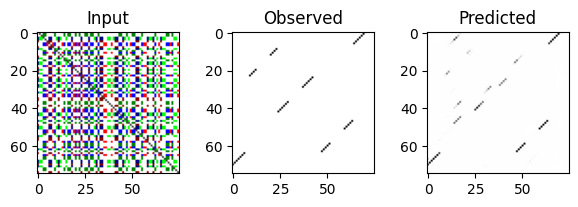

Epoch [1/5], Loss: 0.0073, Validation: 0.21448443830013275


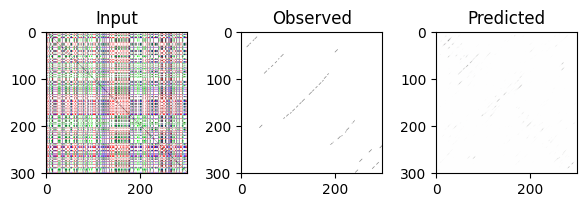

Epoch [2/5], Loss: 0.004, Validation: 0.04302503541111946


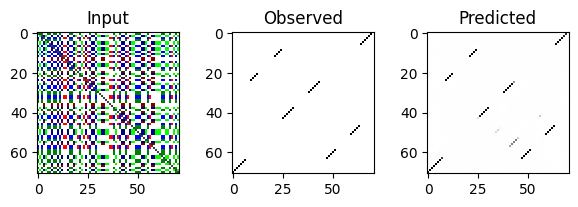

Epoch [3/5], Loss: 0.0036, Validation: 0.047169432044029236


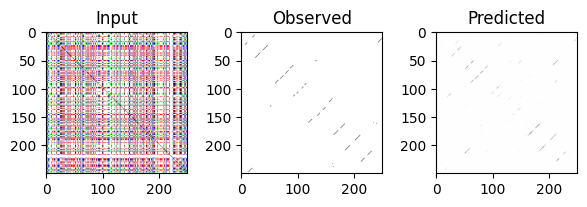

Epoch [4/5], Loss: 0.0034, Validation: 0.11766014993190765


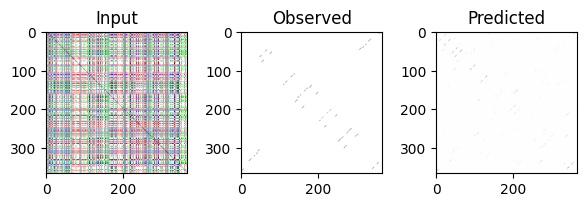

Epoch [5/5], Loss: 0.0033, Validation: 0.03919054940342903


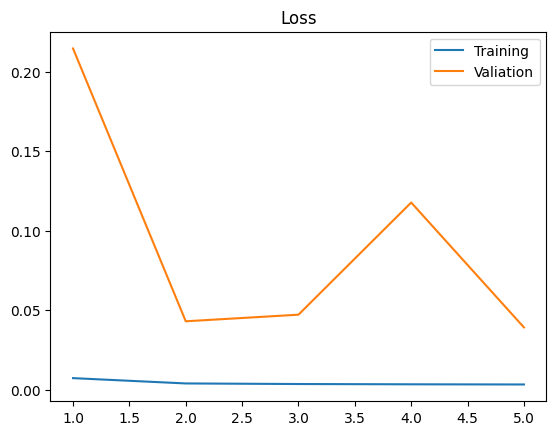

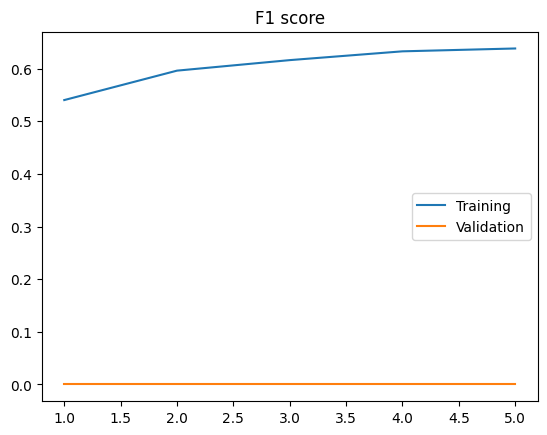

Finished training


In [47]:
#With more layers (Johan) and leaky ReLU
%matplotlib inline

channels = 8
model_Johan_leaky = RNA_Unet12(channels).cuda()
summary(model_Johan_leaky, input_size=(4, 201, 201))

fit_model(model_Johan_leaky, train_dataset, validation_dataset)

print("Finished training")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 208, 208]               0
            Conv2d-2          [-1, 8, 208, 208]             296
       BatchNorm2d-3          [-1, 8, 208, 208]              16
            Conv2d-4          [-1, 8, 208, 208]             584
       BatchNorm2d-5          [-1, 8, 208, 208]              16
            Conv2d-6          [-1, 8, 104, 104]             264
       BatchNorm2d-7          [-1, 8, 104, 104]              16
            Conv2d-8         [-1, 16, 104, 104]           1,168
       BatchNorm2d-9         [-1, 16, 104, 104]              32
           Conv2d-10         [-1, 16, 104, 104]           2,320
      BatchNorm2d-11         [-1, 16, 104, 104]              32
           Conv2d-12           [-1, 16, 52, 52]           1,040
      BatchNorm2d-13           [-1, 16, 52, 52]              32
           Conv2d-14           [-1, 32,

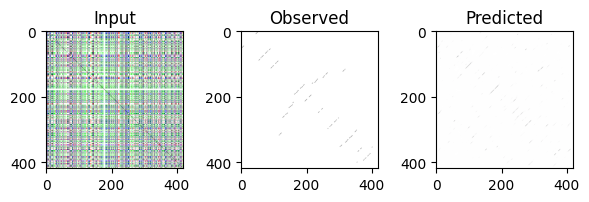

Epoch [1/5], Loss: 0.0149, Validation: 0.006680942606180906


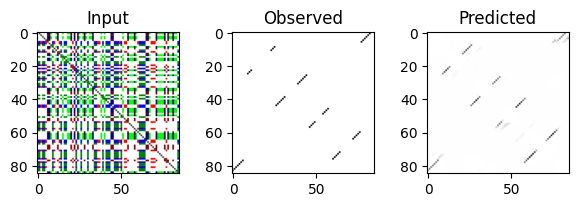

Epoch [2/5], Loss: 0.0064, Validation: 0.006793875712901354


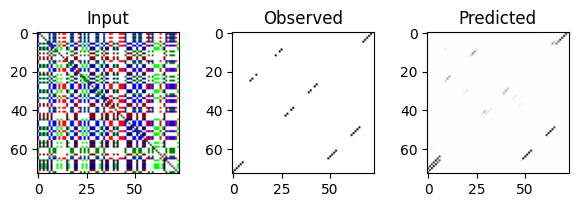

Epoch [3/5], Loss: 0.0055, Validation: 0.006114275194704533


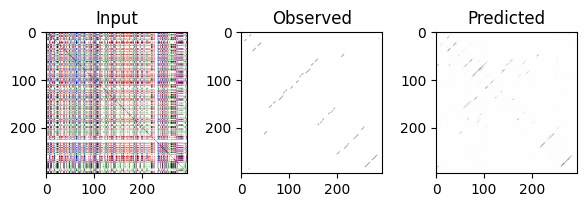

Epoch [4/5], Loss: 0.0049, Validation: 0.005961154587566853


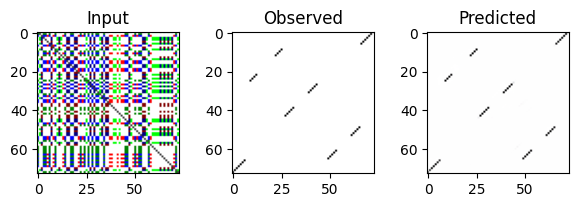

Epoch [5/5], Loss: 0.0046, Validation: 0.005111515522003174


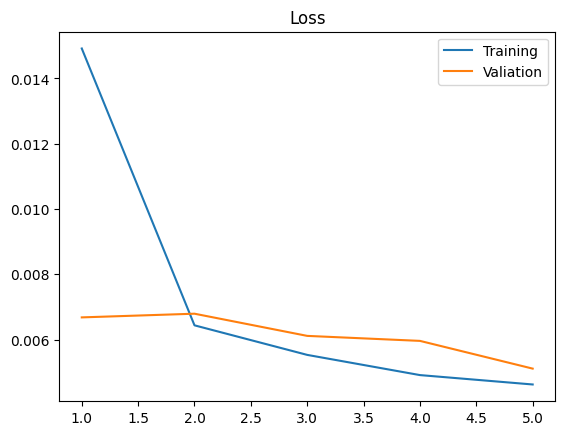

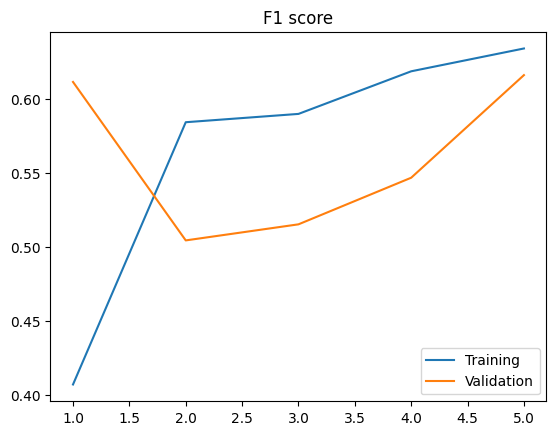

Finished training


In [52]:
#With more layers (Maria)
%matplotlib inline

channels = 8
model_Maria = RNA_Unet21(channels).cuda()
summary(model_Maria, input_size=(4, 201, 201))

fit_model(model_Maria, train_dataset, validation_dataset)

print("Finished training")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 208, 208]               0
            Conv2d-2          [-1, 8, 208, 208]             296
       BatchNorm2d-3          [-1, 8, 208, 208]              16
            Conv2d-4          [-1, 8, 208, 208]             584
       BatchNorm2d-5          [-1, 8, 208, 208]              16
            Conv2d-6          [-1, 8, 104, 104]             264
       BatchNorm2d-7          [-1, 8, 104, 104]              16
            Conv2d-8         [-1, 16, 104, 104]           1,168
       BatchNorm2d-9         [-1, 16, 104, 104]              32
           Conv2d-10         [-1, 16, 104, 104]           2,320
      BatchNorm2d-11         [-1, 16, 104, 104]              32
           Conv2d-12           [-1, 16, 52, 52]           1,040
      BatchNorm2d-13           [-1, 16, 52, 52]              32
           Conv2d-14           [-1, 32,

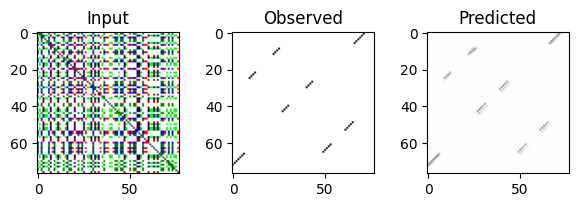

Epoch [1/5], Loss: 0.015, Validation: 0.019518807530403137


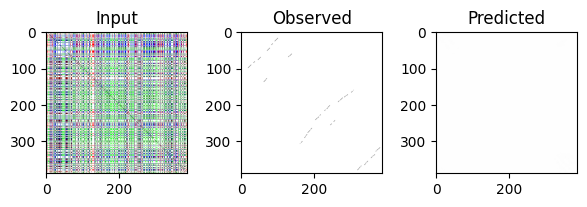

Epoch [2/5], Loss: 0.0095, Validation: 0.01804340071976185


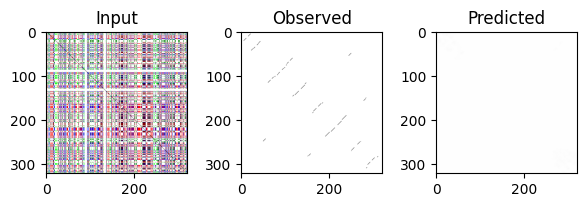

Epoch [3/5], Loss: 0.0077, Validation: 0.018419941887259483


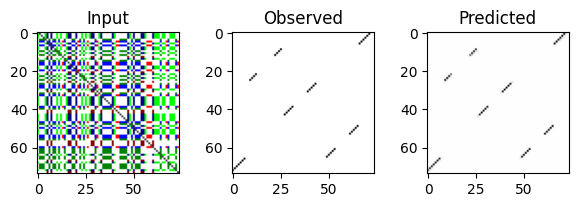

Epoch [4/5], Loss: 0.007, Validation: 0.018893973901867867


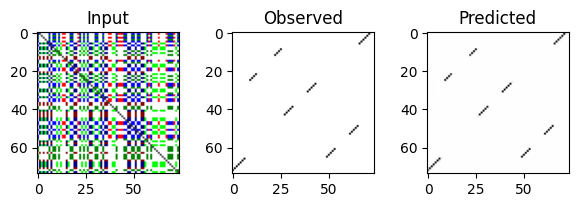

Epoch [5/5], Loss: 0.0065, Validation: 0.016960907727479935


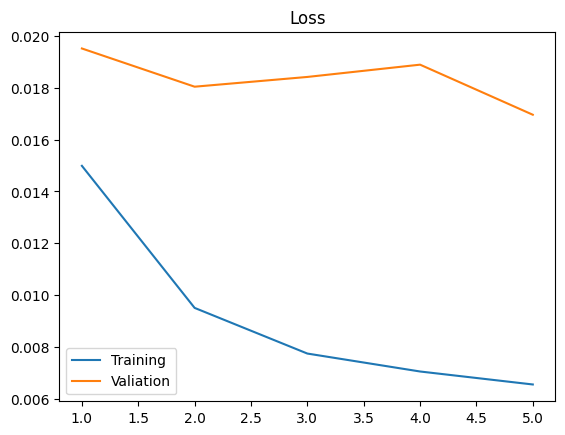

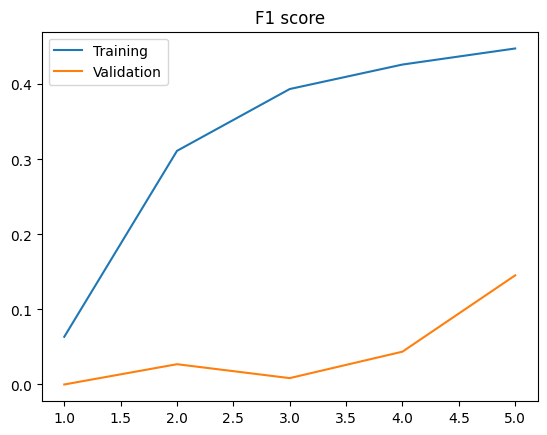

Finished training


In [64]:
#With even more layers (Maria)
%matplotlib inline

channels = 8
model_Maria2 = RNA_Unet22(channels).cuda()
summary(model_Maria2, input_size=(4, 201, 201))

fit_model(model_Maria2, train_dataset, validation_dataset)

print("Finished training")

In [34]:
#With even more layers (Maria)
%matplotlib inline

channels = 8
model_Maria2 = RNA_Unet22(channels).cuda()
summary(model_Maria2, input_size=(4, 201, 201))

fit_model(model_Maria2, train_dataset, validation_dataset, lr=0.03)

print("Finished training")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 208, 208]               0
            Conv2d-2          [-1, 8, 208, 208]             296
       BatchNorm2d-3          [-1, 8, 208, 208]              16
            Conv2d-4          [-1, 8, 208, 208]             584
       BatchNorm2d-5          [-1, 8, 208, 208]              16
            Conv2d-6          [-1, 8, 104, 104]             264
       BatchNorm2d-7          [-1, 8, 104, 104]              16
            Conv2d-8         [-1, 16, 104, 104]           1,168
       BatchNorm2d-9         [-1, 16, 104, 104]              32
           Conv2d-10         [-1, 16, 104, 104]           2,320
      BatchNorm2d-11         [-1, 16, 104, 104]              32
           Conv2d-12           [-1, 16, 52, 52]           1,040
      BatchNorm2d-13           [-1, 16, 52, 52]              32
           Conv2d-14           [-1, 32,

KeyboardInterrupt: ignored

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 208, 208]               0
            Conv2d-2          [-1, 8, 208, 208]             296
       BatchNorm2d-3          [-1, 8, 208, 208]              16
            Conv2d-4          [-1, 8, 208, 208]             584
       BatchNorm2d-5          [-1, 8, 208, 208]              16
            Conv2d-6          [-1, 8, 104, 104]             264
       BatchNorm2d-7          [-1, 8, 104, 104]              16
            Conv2d-8         [-1, 16, 104, 104]           1,168
       BatchNorm2d-9         [-1, 16, 104, 104]              32
           Conv2d-10         [-1, 16, 104, 104]           2,320
      BatchNorm2d-11         [-1, 16, 104, 104]              32
           Conv2d-12           [-1, 16, 52, 52]           1,040
      BatchNorm2d-13           [-1, 16, 52, 52]              32
           Conv2d-14           [-1, 32,

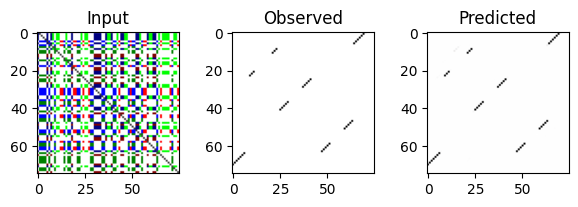

Epoch [1/5], Loss: 0.0057, Validation: 0.006114219781011343


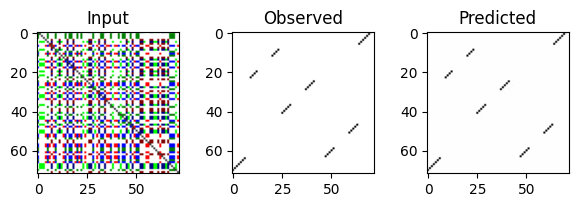

Epoch [2/5], Loss: 0.0025, Validation: 0.0066121905110776424


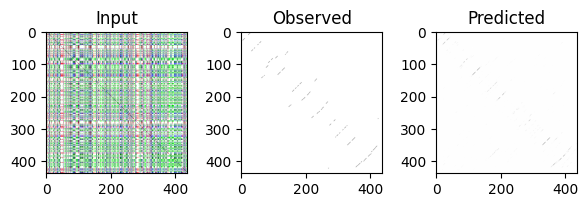

Epoch [3/5], Loss: 0.002, Validation: 0.008689112961292267


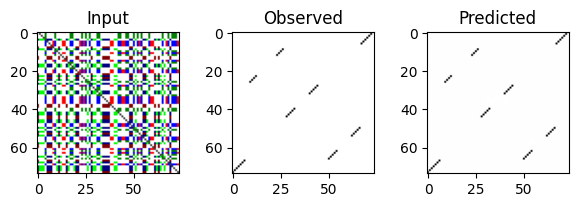

Epoch [4/5], Loss: 0.0018, Validation: 0.010839001275599003


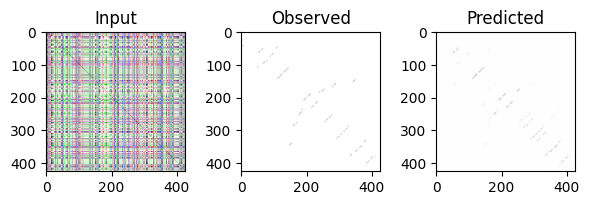

Epoch [5/5], Loss: 0.0016, Validation: 0.009340519085526466


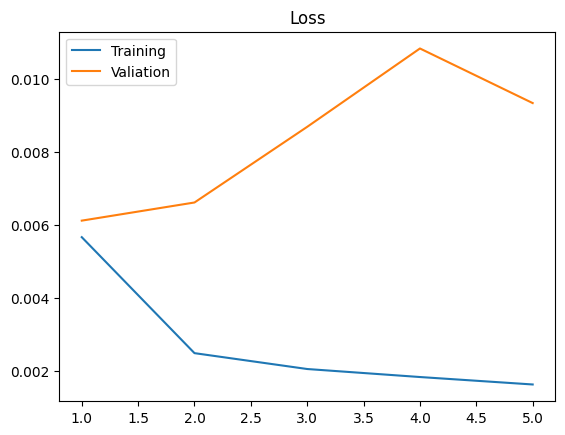

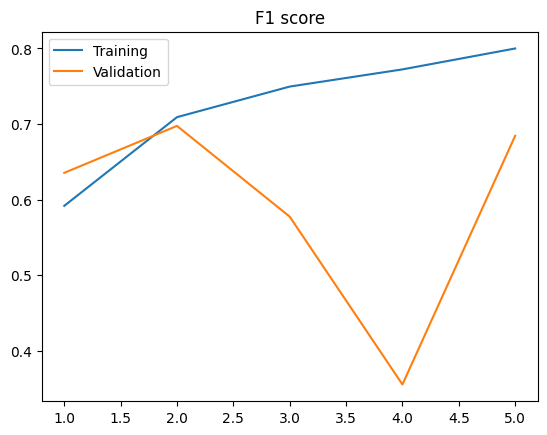

Finished training


In [37]:
#With skip layers
%matplotlib inline

channels = 8
model_unet_skipl = RNA_Unet_skipl(channels).cuda()
summary(model_unet_skipl, input_size=(4, 201, 201))

fit_model(model_unet_skipl, train_dataset, validation_dataset)

print("Finished training")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 208, 208]               0
            Conv2d-2          [-1, 8, 208, 208]             296
       BatchNorm2d-3          [-1, 8, 208, 208]              16
            Conv2d-4          [-1, 8, 208, 208]             584
       BatchNorm2d-5          [-1, 8, 208, 208]              16
            Conv2d-6          [-1, 8, 104, 104]             264
       BatchNorm2d-7          [-1, 8, 104, 104]              16
            Conv2d-8         [-1, 16, 104, 104]           1,168
       BatchNorm2d-9         [-1, 16, 104, 104]              32
           Conv2d-10         [-1, 16, 104, 104]           2,320
      BatchNorm2d-11         [-1, 16, 104, 104]              32
           Conv2d-12           [-1, 16, 52, 52]           1,040
      BatchNorm2d-13           [-1, 16, 52, 52]              32
           Conv2d-14           [-1, 32,

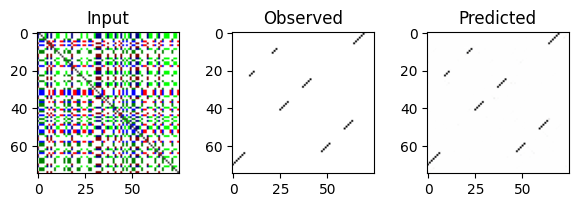

Epoch [1/5], Loss: 0.0008, Validation: tensor([0.0007], device='cuda:0')


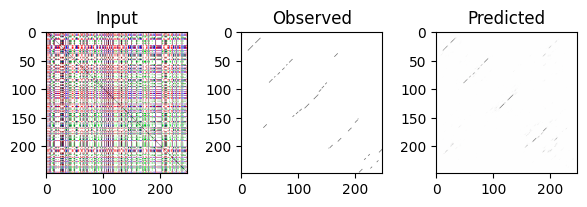

Epoch [2/5], Loss: 0.0003, Validation: tensor([0.0006], device='cuda:0')


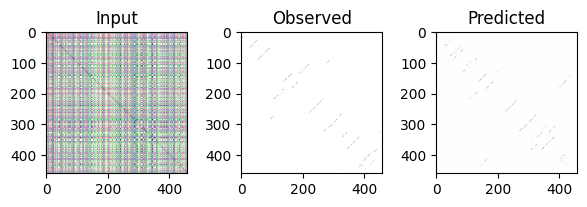

Epoch [3/5], Loss: 0.0003, Validation: tensor([0.0008], device='cuda:0')


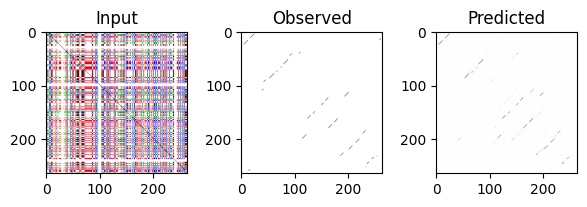

Epoch [4/5], Loss: 0.0002, Validation: tensor([0.0005], device='cuda:0')


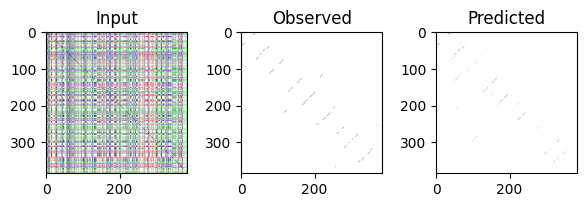

Epoch [5/5], Loss: 0.0002, Validation: tensor([0.0008], device='cuda:0')


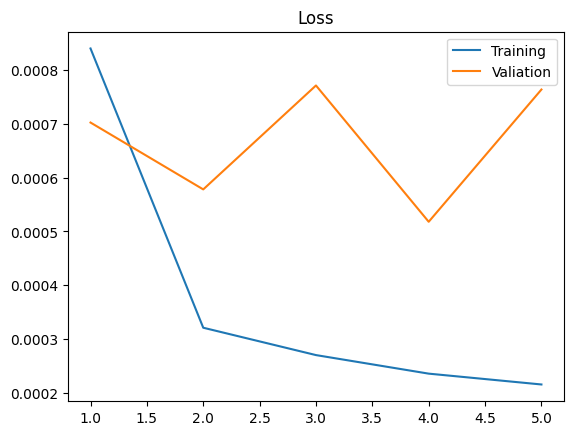

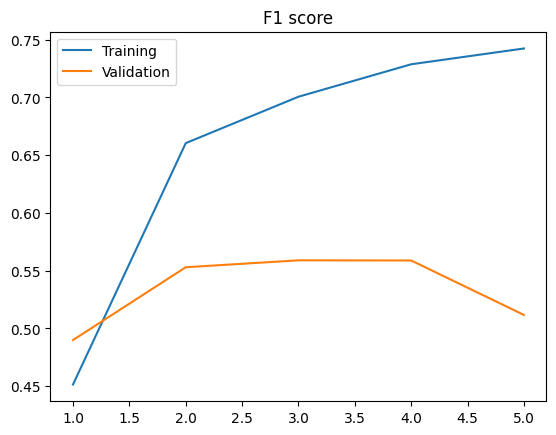

Finished training


In [38]:
#With dice loss
%matplotlib inline

channels = 8
model_dice = RNA_Unet_skipl(channels).cuda()
summary(model_dice, input_size=(4, 201, 201))

fit_model(model_dice, train_dataset, validation_dataset, loss_func = dice_loss)

print("Finished training")